# Uber Driver Data Analysis

This notebook analyzes driver performance, earnings, and behavior patterns from the Uber hackathon dataset.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

In [2]:
# ---------------------------
# Load all sheets from the Excel file
# ---------------------------
file_path = "uber_hackathon_v2_mock_data.xlsx"
sheets = pd.read_excel(file_path, sheet_name=None)

# Assign sheets to variables
earners = sheets['earners']
rides_trips = sheets['rides_trips']
earnings_daily = sheets['earnings_daily']
incentives_weekly = sheets['incentives_weekly']
cancellation_rates = sheets['cancellation_rates']
surge_by_hour = sheets.get('surge_by_hour')        # optional
weather_daily = sheets.get('weather_daily')        # optional
heatmap_sheet = sheets.get('heatmap')              # optional
jobs_like = sheets.get('jobs_like')                # optional

# Convert datetime columns
rides_trips['start_time'] = pd.to_datetime(rides_trips['start_time'])
rides_trips['end_time'] = pd.to_datetime(rides_trips['end_time'])
earnings_daily['date'] = pd.to_datetime(earnings_daily['date'])

print(f"Loaded {len(sheets)} sheets from {file_path}")
print(f"\nEarners: {len(earners)} records")
print(f"Rides/Trips: {len(rides_trips)} records")
print(f"Daily Earnings: {len(earnings_daily)} records")
print(f"Weekly Incentives: {len(incentives_weekly)} records")

Loaded 14 sheets from uber_hackathon_v2_mock_data.xlsx

Earners: 360 records
Rides/Trips: 3000 records
Daily Earnings: 5270 records
Weekly Incentives: 3622 records


## 2. Earnings vs Working Time

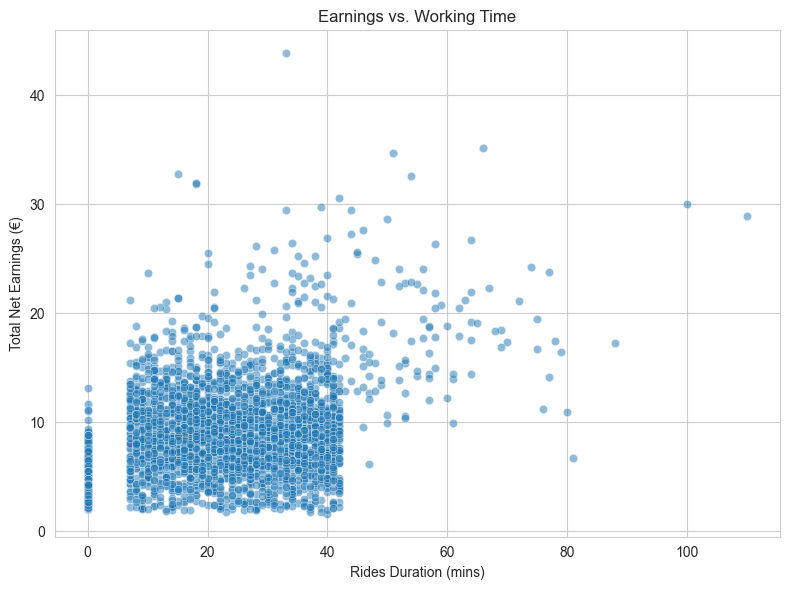

In [3]:
# ---------------------------
# 1. Earnings vs Working Time
# ---------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x='rides_duration_mins', y='total_net_earnings', data=earnings_daily, alpha=0.5)
plt.title('Earnings vs. Working Time')
plt.xlabel('Rides Duration (mins)')
plt.ylabel('Total Net Earnings (€)')
plt.tight_layout()
plt.show()

## 3. Trips per Day Distribution

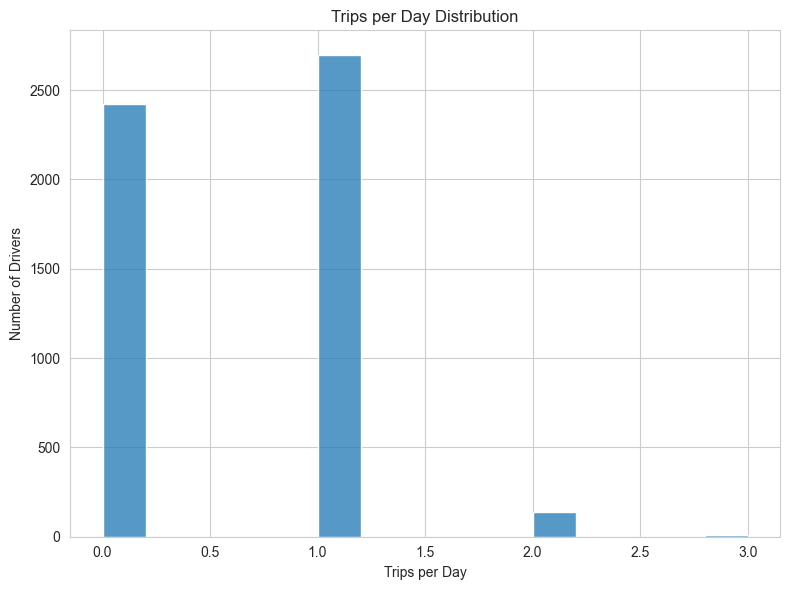

In [4]:
# ---------------------------
# 2. Trips per Day Distribution
# ---------------------------
plt.figure(figsize=(8,6))
sns.histplot(earnings_daily['trips_count'], bins=15, kde=False)
plt.title('Trips per Day Distribution')
plt.xlabel('Trips per Day')
plt.ylabel('Number of Drivers')
plt.tight_layout()
plt.show()

## 4. Hourly Earnings Curve

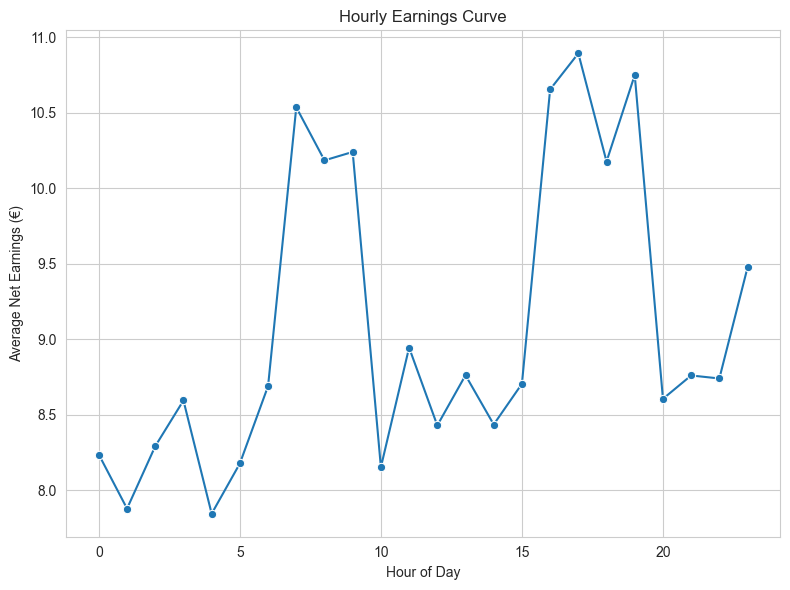

In [5]:
# ---------------------------
# 3. Hourly Earnings Curve
# ---------------------------
rides_trips['hour'] = rides_trips['start_time'].dt.hour
hourly_earnings = rides_trips.groupby('hour')['net_earnings'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(x='hour', y='net_earnings', data=hourly_earnings, marker='o')
plt.title('Hourly Earnings Curve')
plt.xlabel('Hour of Day')
plt.ylabel('Average Net Earnings (€)')
plt.tight_layout()
plt.show()

## 5. Idle Time Analysis

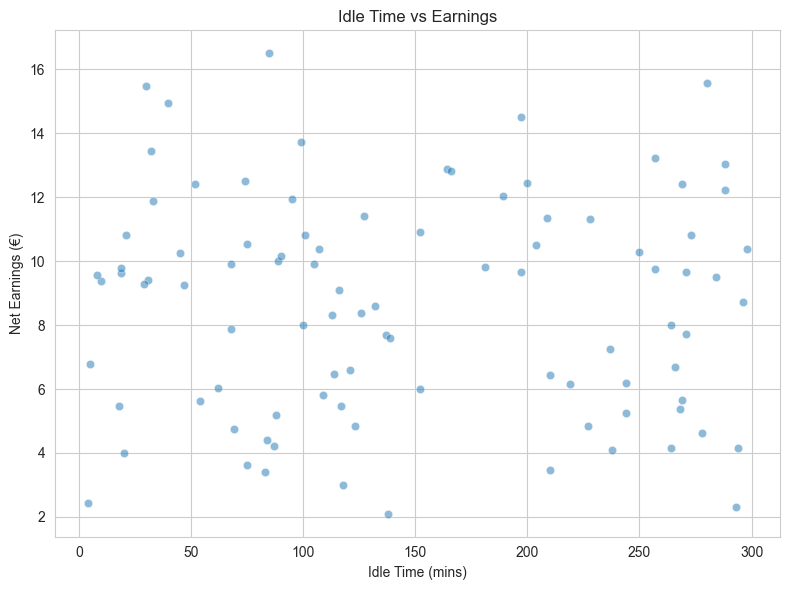

In [6]:
# ---------------------------
# 4. Idle Time Analysis
# ---------------------------
rides_trips_sorted = rides_trips.sort_values(['driver_id','start_time'])
rides_trips_sorted['next_start'] = rides_trips_sorted.groupby('driver_id')['start_time'].shift(-1)
rides_trips_sorted['idle_time_mins'] = (rides_trips_sorted['next_start'] - rides_trips_sorted['end_time']).dt.total_seconds()/60

# Filter out negative and extreme values
rides_trips_filtered = rides_trips_sorted[(rides_trips_sorted['idle_time_mins'] > 0) & 
                                           (rides_trips_sorted['idle_time_mins'] < 300)]

plt.figure(figsize=(8,6))
sns.scatterplot(x='idle_time_mins', y='net_earnings', data=rides_trips_filtered, alpha=0.5)
plt.title('Idle Time vs Earnings')
plt.xlabel('Idle Time (mins)')
plt.ylabel('Net Earnings (€)')
plt.tight_layout()
plt.show()

## 6. Weekly Incentives Effect

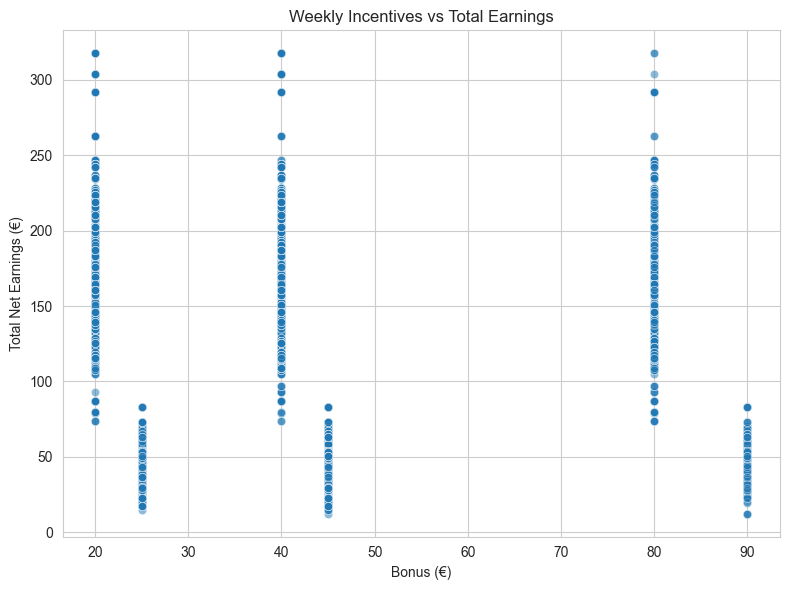

In [7]:
# ---------------------------
# 5. Weekly Incentives Effect
# ---------------------------
weekly_earnings = earnings_daily.groupby('earner_id').agg({'total_net_earnings':'sum'}).reset_index()
weekly_data = weekly_earnings.merge(incentives_weekly, on='earner_id', how='left')
plt.figure(figsize=(8,6))
sns.scatterplot(x='bonus_eur', y='total_net_earnings', data=weekly_data, alpha=0.5)
plt.title('Weekly Incentives vs Total Earnings')
plt.xlabel('Bonus (€)')
plt.ylabel('Total Net Earnings (€)')
plt.tight_layout()
plt.show()

## 7. Driver Rating vs Workload

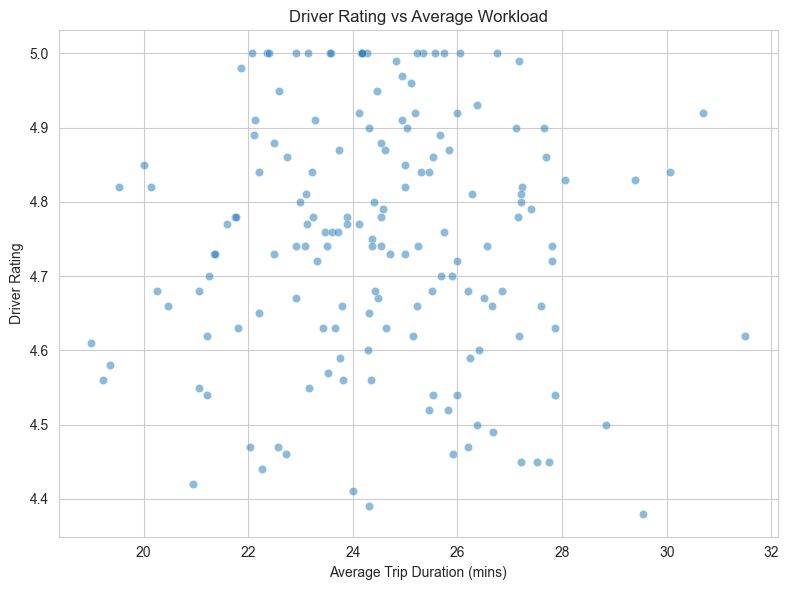

In [8]:
# ---------------------------
# 6. Driver Rating vs Workload
# ---------------------------
driver_workload = rides_trips.groupby('driver_id')['duration_mins'].mean().reset_index()
rating_workload = driver_workload.merge(earners[['earner_id','rating']], 
                                         left_on='driver_id', 
                                         right_on='earner_id', 
                                         how='left')
plt.figure(figsize=(8,6))
sns.scatterplot(x='duration_mins', y='rating', data=rating_workload, alpha=0.5)
plt.title('Driver Rating vs Average Workload')
plt.xlabel('Average Trip Duration (mins)')
plt.ylabel('Driver Rating')
plt.tight_layout()
plt.show()

## 8. Cancellation Rate vs Surge

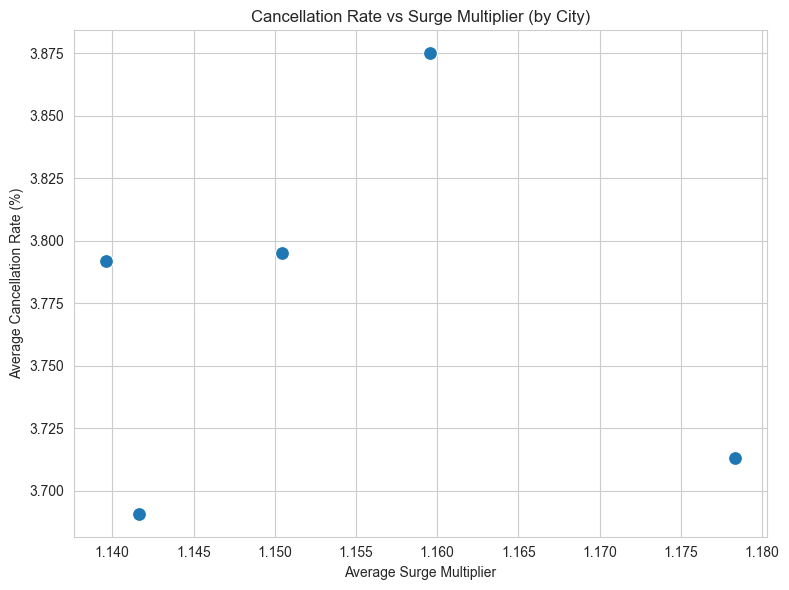

In [9]:
# ---------------------------
# 7. Cancellation Rate vs Surge
# ---------------------------
if surge_by_hour is not None:
    # Add hour column to cancellation_rates if needed
    # For this analysis, we'll aggregate by city
    cancellation_city = cancellation_rates.groupby('city_id').agg({
        'cancellation_rate_pct': 'mean'
    }).reset_index()
    
    surge_city = surge_by_hour.groupby('city_id').agg({
        'surge_multiplier': 'mean'
    }).reset_index()
    
    cancellation_surge = cancellation_city.merge(surge_city, on='city_id', how='left')
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='surge_multiplier', y='cancellation_rate_pct', 
                    data=cancellation_surge, s=100)
    plt.title('Cancellation Rate vs Surge Multiplier (by City)')
    plt.xlabel('Average Surge Multiplier')
    plt.ylabel('Average Cancellation Rate (%)')
    plt.tight_layout()
    plt.show()
else:
    print("Surge data not available")

## 9. Fatigue Heatmap - Trips by Hour and Day

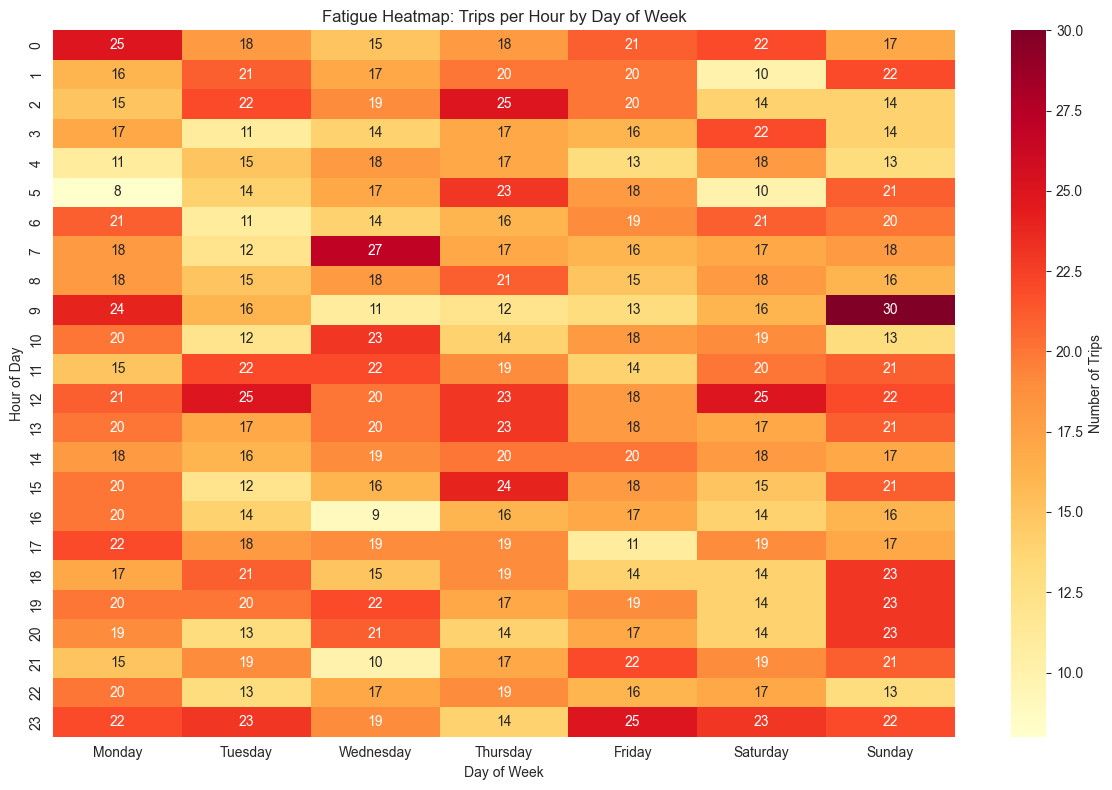

In [10]:
# ---------------------------
# 8. Fatigue Heatmap
# ---------------------------
rides_trips['day_of_week'] = rides_trips['start_time'].dt.day_name()
heatmap_data = rides_trips.pivot_table(index='hour', 
                                        columns='day_of_week', 
                                        values='ride_id', 
                                        aggfunc='count')

# Reorder columns to show days in proper order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[[col for col in day_order if col in heatmap_data.columns]]

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g', cbar_kws={'label': 'Number of Trips'})
plt.title('Fatigue Heatmap: Trips per Hour by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

In [55]:
# ---------------------------
# Load DataFrame from CSV file
# ---------------------------

# Method 1: Basic CSV loading
# Replace 'your_file.csv' with your actual CSV file path
csv_file_path = "data\data-1759588094558.csv"

try:
    # Load CSV into DataFrame
    df = pd.read_csv(csv_file_path)
    
    print(f"Successfully loaded CSV: {csv_file_path}")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst 5 rows:")
    display(df.head())
    
except FileNotFoundError:
    print(f"File '{csv_file_path}' not found. Please check the file path.")
except Exception as e:
    print(f"Error loading CSV: {e}")



Successfully loaded CSV: data\data-1759588094558.csv
Shape: (5453, 4)
Columns: ['city', 'latitude', 'longitude', 'predicted_eph']

First 5 rows:


,city,latitude,longitude,predicted_eph
0,1,52.41329,4.86934,22.18
1,1,52.36698,4.93160,18.15
2,1,52.41348,4.90340,21.24
3,1,52.36189,4.89963,25.47
4,1,52.36991,4.94270,24.13


<Axes: xlabel='longitude', ylabel='latitude'>

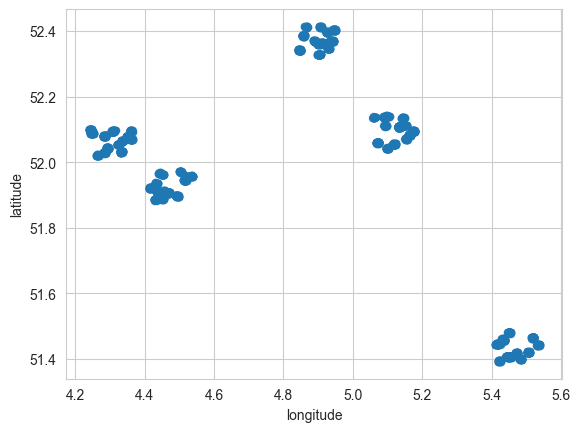

In [80]:
df.sort_values(['city', 'latitude', 'longitude'], ascending=[False, False, False])  
df[df['city']==1].describe()
df.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5,)
# Locationaldf=df.set_index(['city', 'latitude', 'longitude'])["predicted_eph"].to_frame()
# Locationaldf.head()

In [67]:
cityArray= []
for i in range(1, 6):
    cityArray.append(df[df['city']==i])
cityArray[0].describe()


,city,latitude,longitude,predicted_eph
count,1029.0,1029.000000,1029.000000,1029.000000
mean,1.0,52.371174,4.902909,21.384742
std,0.0,0.025050,0.033365,5.008751
min,1.0,52.325730,4.841580,8.000000
25%,1.0,52.358810,4.867790,17.890000
50%,1.0,52.367360,4.906330,21.340000
75%,1.0,52.394590,4.931440,24.970000
max,1.0,52.415680,4.951150,35.000000


<Axes: xlabel='pickup_lon', ylabel='pickup_lat'>

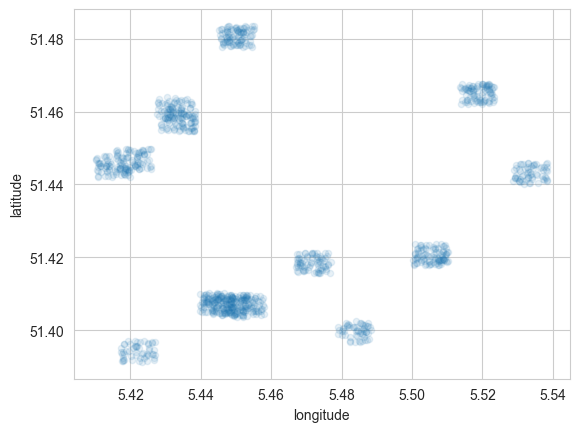

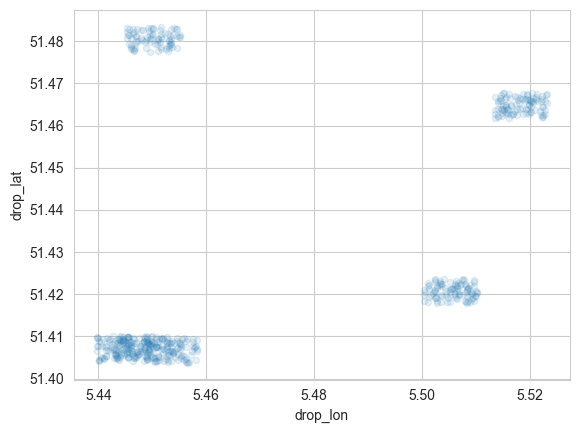

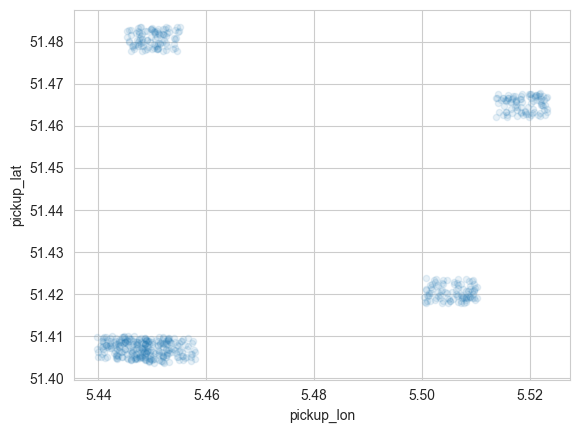

In [87]:
cityArray[3].plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
rides_trips[rides_trips['city_id']==4].plot(kind='scatter', x='drop_lon', y='drop_lat', alpha=0.1)
rides_trips[rides_trips['city_id']==4].plot(kind='scatter', x='pickup_lon', y='pickup_lat', alpha=0.1)


In [77]:
i=1
latdif = cityArray[i]['latitude'].max() - cityArray[i]['latitude'].min()
longdif = cityArray[i]['longitude'].max() - cityArray[i]['longitude'].min()
cityArray[i]["latsector"] = 0
cityArray[i]["longsector"] = 0
for j in range(1, 101):
    lat = cityArray[i].loc[cityArray[i]['latitude'].between(cityArray[i]['latitude'].quantile(0.01*(i-1)), cityArray[i]['latitude'].quantile(0.01*i)), 'latsector'] = j
    # lat = cityArray[i]['latitude'].min() + (latdif * j / 100)
    if cityArray[i]['latitude'].between(lat - (latdif / 100), lat).any():
        cityArray[i].loc[cityArray[i]['latitude'].between(lat - (latdif / 100), lat), 'latsector'] = j
    # long = cityArray[i]['longitude'].min() + (longdif * j / 100)
    long = cityArray[i].loc[cityArray[i]['longitude'].between(cityArray[i]['longitude'].quantile(0.01*(i-1)), cityArray[i]['longitude'].quantile(0.01*i)), 'longsector'] = j
    if cityArray[i]['longitude'].between(long - (longdif / 100), long).any():
        cityArray[i].loc[cityArray[i]['longitude'].between(long - (longdif / 100), long), 'longsector'] = j
cityArray[i].sort_values(['latsector', 'longsector'], ascending=[True, True], inplace=True)
cityArray[i].describe()


,city,latitude,longitude,predicted_eph,latsector,longsector
count,1112.0,1112.000000,1112.000000,1112.000000,1112.000000,1112.000000
mean,2.0,51.927514,4.470646,21.021520,1.079137,1.079137
std,0.0,0.028393,0.036932,4.922836,10.336596,10.336596
min,2.0,51.883310,4.412120,8.000000,0.000000,0.000000
25%,2.0,51.905608,4.438390,17.730000,0.000000,0.000000
50%,2.0,51.921222,4.456442,20.975000,0.000000,0.000000
75%,2.0,51.956028,4.508242,24.380000,0.000000,0.000000
max,2.0,51.973980,4.539790,35.000000,100.000000,100.000000


<Axes: xlabel='longsector', ylabel='latsector'>

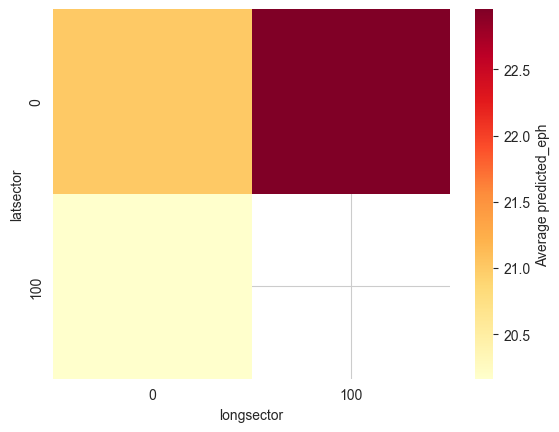

In [76]:
test = cityArray[i].groupby(['latsector', 'longsector'])['predicted_eph'].mean().unstack()
sns.heatmap(test, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Average predicted_eph'})